### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score

### Loading Dataset

In [2]:
df = pd.read_csv("learning_traces.13m.csv")
display(df.head())

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,1362076081,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,1362076081,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,1362076081,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,1362076081,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,1362076081,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


### Exploratory Data Analysis

In [3]:
df.shape

(12854226, 12)

In [4]:
df.describe()

,p_recall,timestamp,delta,history_seen,history_correct,session_seen,session_correct
count,1.285423e+07,1.285423e+07,1.285423e+07,1.285423e+07,1.285423e+07,1.285423e+07,1.285423e+07
mean,8.961056e-01,1.362589e+09,7.295811e+05,2.198109e+01,1.935025e+01,1.817686e+00,1.644134e+00
std,2.714048e-01,2.932082e+05,2.246499e+06,1.295508e+02,1.119681e+02,1.360180e+00,1.318794e+00
min,0.000000e+00,1.362076e+09,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00
25%,1.000000e+00,1.362343e+09,5.320000e+02,3.000000e+00,3.000000e+00,1.000000e+00,1.000000e+00
50%,1.000000e+00,1.362591e+09,7.713400e+04,6.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00
75%,1.000000e+00,1.362846e+09,4.425070e+05,1.500000e+01,1.300000e+01,2.000000e+00,2.000000e+00
max,1.000000e+00,1.363105e+09,4.032836e+07,1.351800e+04,1.288800e+04,2.000000e+01,2.000000e+01


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12854226 entries, 0 to 12854225
Data columns (total 12 columns):
 #   Column             Dtype  
---  ------             -----  
 0   p_recall           float64
 1   timestamp          int64  
 2   delta              int64  
 3   user_id            object 
 4   learning_language  object 
 5   ui_language        object 
 6   lexeme_id          object 
 7   lexeme_string      object 
 8   history_seen       int64  
 9   history_correct    int64  
 10  session_seen       int64  
 11  session_correct    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 1.1+ GB


In [6]:
# Converting timestamp to a readable date format
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')

display(df.head())

,p_recall,timestamp,delta,user_id,learning_language,ui_language,lexeme_id,lexeme_string,history_seen,history_correct,session_seen,session_correct
0,1.0,2013-02-28 18:28:01,27649635,u:FO,de,en,76390c1350a8dac31186187e2fe1e178,lernt/lernen<vblex><pri><p3><sg>,6,4,2,2
1,0.5,2013-02-28 18:28:01,27649635,u:FO,de,en,7dfd7086f3671685e2cf1c1da72796d7,die/die<det><def><f><sg><nom>,4,4,2,1
2,1.0,2013-02-28 18:28:01,27649635,u:FO,de,en,35a54c25a2cda8127343f6a82e6f6b7d,mann/mann<n><m><sg><nom>,5,4,1,1
3,0.5,2013-02-28 18:28:01,27649635,u:FO,de,en,0cf63ffe3dda158bc3dbd55682b355ae,frau/frau<n><f><sg><nom>,6,5,2,1
4,1.0,2013-02-28 18:28:01,27649635,u:FO,de,en,84920990d78044db53c1b012f5bf9ab5,das/das<det><def><nt><sg><nom>,4,4,1,1


In [7]:
# Checking for null values
df.isnull().sum()

p_recall             0
timestamp            0
delta                0
user_id              0
learning_language    0
ui_language          0
lexeme_id            0
lexeme_string        0
history_seen         0
history_correct      0
session_seen         0
session_correct      0
dtype: int64

### Visualizations

#### Most Commonly Learned Languages

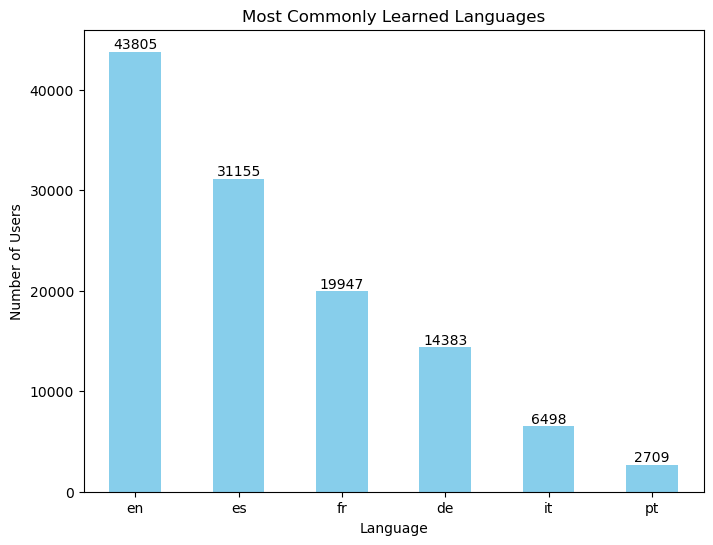

In [8]:
# Unique users
unique_users = df.drop_duplicates(subset=['user_id', 'learning_language'])

# Counting the number of languages being learned
lang_counts = unique_users['learning_language'].value_counts()

# plotting histogram
plt.figure(figsize=(8,6))
bars = lang_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Most Commonly Learned Languages')
plt.xlabel('Language')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)

# Annotate bars
for bar in bars.patches:
    plt.annotate(bar.get_height(),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha ='center', va = 'bottom')
plt.show()

#### Most Commonly Learned Languages by English Speakers

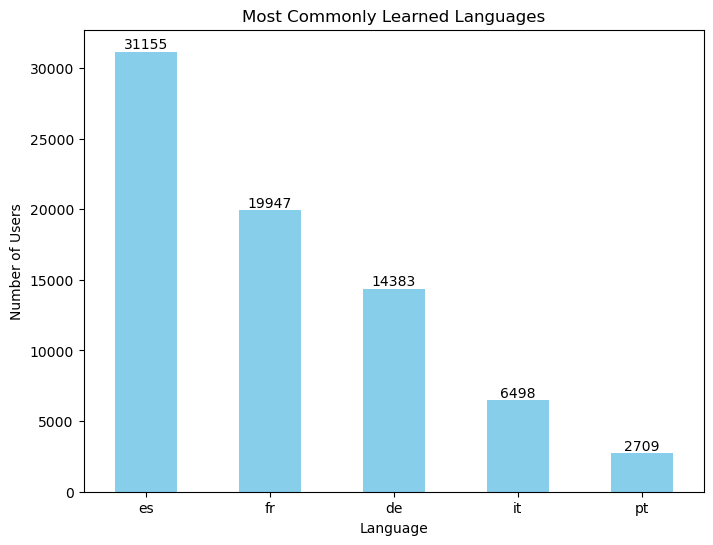

In [9]:
# Filter to english speakers
eng_speakers = df[df['ui_language']=='en']

# Unique users
unique_users = eng_speakers.drop_duplicates(subset=['user_id', 'learning_language'])

# Counting the number of languages being learned
lang_counts = unique_users['learning_language'].value_counts()

# plotting histogram
plt.figure(figsize=(8,6))
bars = lang_counts.plot(kind='bar', color='skyblue')

# Adding titles and labels
plt.title('Most Commonly Learned Languages')
plt.xlabel('Language')
plt.ylabel('Number of Users')
plt.xticks(rotation=0)

# Annotate bars
for bar in bars.patches:
    plt.annotate(bar.get_height(),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha ='center', va = 'bottom')
plt.show()

#### What UI Language users are Learning English

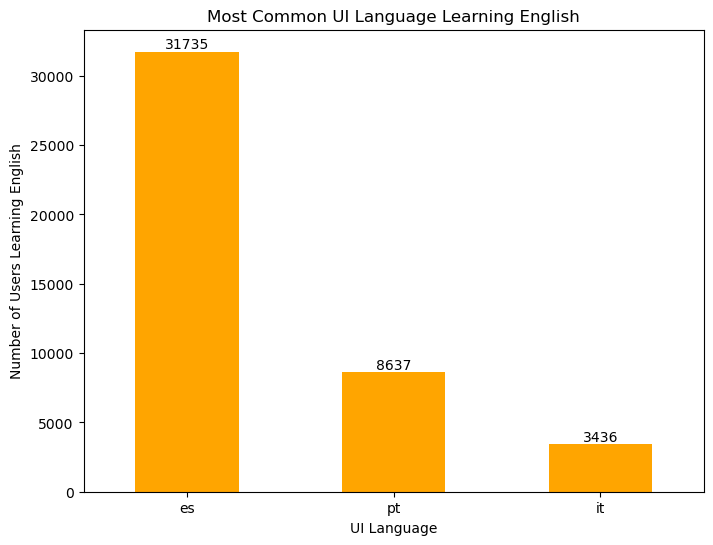

In [10]:
# Filter to english learners
eng_learners = df[df['learning_language']=='en']

# Unique users
unique_users = eng_learners.drop_duplicates(subset=['user_id', 'ui_language'])

# Counting the number of languages being learned
lang_counts = unique_users['ui_language'].value_counts()

# plotting histogram
plt.figure(figsize=(8,6))
bars = lang_counts.plot(kind='bar', color='orange')

# Adding titles and labels
plt.title('Most Common UI Language Learning English')
plt.xlabel('UI Language')
plt.ylabel('Number of Users Learning English')
plt.xticks(rotation=0)

# Annotate bars
for bar in bars.patches:
    plt.annotate(bar.get_height(),
                 (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 ha ='center', va = 'bottom')
plt.show()

session accuracy against history seen
time based activity
consecutive days engagement
week patterns


### User Engagement Metrics

- Group by user and group by day and count how many users use the app for how many hours/day
- Week overview -> do people use it more on weekends or weekdays?
- 

#### Trend over Week

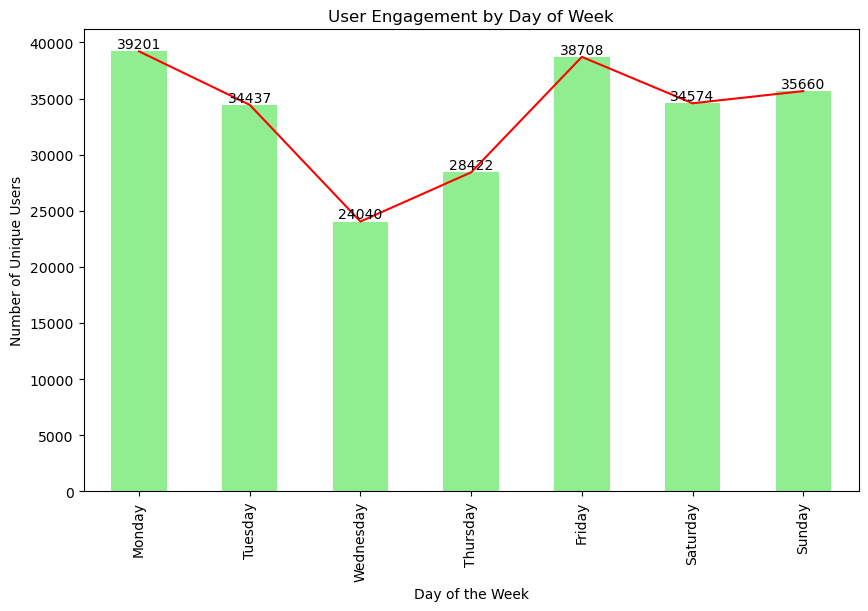

In [11]:
# Extract day from timestamp
df['day_of_week'] = df['timestamp'].dt.day_name()

user_counts_per_day = (
    df.groupby('day_of_week')['user_id'].nunique()
    .reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
)

# Plot
plt.figure(figsize=(10,6))
user_counts_per_day.plot(kind='bar', color='lightgreen')
# Adding line trend
plt.plot(user_counts_per_day.index, user_counts_per_day.values, color = 'red', linestyle='-')
# Adding labels above each bar
for i, value in enumerate(user_counts_per_day.values):
    plt.text(i, value + 10, str(value), ha='center', va='bottom', fontsize=10, color='black')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Unique Users')
plt.title('User Engagement by Day of Week')
plt.show()



## Activity by Time

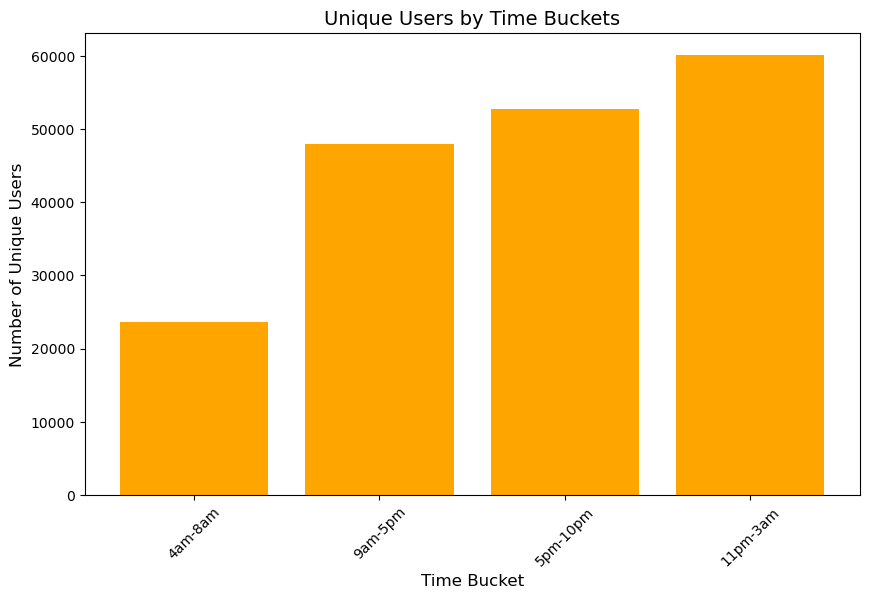

In [23]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit = 's')

# Extract the hour and categorize  into time buckets
def assign_time_bucket(hour):
    if 4 <= hour < 8:
        return '4am-8am'
    elif 9 <= hour < 17:
        return '9am-5pm'
    elif 17 <= hour < 22:
        return '5pm-10pm'
    else:
        return '11pm-3am'

df['time_bucket'] = df['timestamp'].dt.hour.apply(assign_time_bucket)

# Count unique users in each time bucket
unique_users = df.groupby('time_bucket')['user_id'].nunique().reset_index()
unique_users.columns = ['time_bucket', 'unique_users']

# Order the time buckets
time_order = ['4am-8am', '9am-5pm', '5pm-10pm', '11pm-3am']
unique_users['time_bucket'] = pd.Categorical(unique_users['time_bucket'], categories=time_order, ordered=True)
unique_users = unique_users.sort_values('time_bucket')


# Visualization
plt.figure(figsize=(10, 6))
plt.bar(unique_users['time_bucket'], unique_users['unique_users'], color='orange')
plt.title('Unique Users by Time Buckets', fontsize=14)
plt.xlabel('Time Bucket', fontsize=12)
plt.ylabel('Number of Unique Users', fontsize=12)
plt.xticks(rotation=45)
plt.show()